In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import ast
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd
from itertools import combinations
from functions import *

In [75]:
#Function version for numbers eks 1 and eks 2


def proportions(D,num_of_groups,num_of_rounds):
    list_of_proportions_groupwise = [[] for _ in range(num_of_groups)]

    for i in range(0, len(D)):
        wait_time = D.iloc[i, 0]
        correct_str = D.iloc[i, 1]
        guess_str   = D.iloc[i, 2]
        
        # Compute success rate
        success_rate = calculate_correct_and_success_rate(correct_str, guess_str)

        list_of_proportions_groupwise[i // num_of_rounds].append(success_rate)
    return list_of_proportions_groupwise

def calculate_correct_and_success_rate(correct_str, guess_str):
    correct_list = re.findall(r"\d+", correct_str)
    guess_list   = re.findall(r"\d+", guess_str)
    n = len(correct_list)
    num_of_correct = sum(g in correct_list for g in guess_list)
    success_rate = num_of_correct / n if n else 0
    return success_rate

In [76]:
def format_p_value_latex(p):
    """
    Formats a p-value into a LaTeX-compatible string.
    - Uses scientific notation for p < 0.001.
    - Uses standard decimal format for p >= 0.001.
    - Handles non-numeric values gracefully.
    """

    if not isinstance(p, (int, float)) or pd.isna(p):
        return p

    if p < 0.001:
        sci_notation = f"{p:.2e}"
        mantissa, exponent = sci_notation.split('e')
        return f"${mantissa} \\times 10^{{{int(exponent)}}}$"
    else:
        return f"{p:.3f}"


In [77]:
#Function version for letter


def letters_proportions(D,num_of_groups,num_of_rounds):
    list_of_proportions_groupwise = [[] for _ in range(num_of_groups)]

    for i in range(0, len(D)):
        wait_time = D.iloc[i, 0]
        correct_str = D.iloc[i, 1]
        guess_str   = D.iloc[i, 2]
        
        # Compute success rate
        success_rate = letters_calculate_correct_and_success_rate(correct_str, guess_str)

        list_of_proportions_groupwise[i // num_of_rounds].append(success_rate)
    return list_of_proportions_groupwise

def letters_calculate_correct_and_success_rate(correct_str, guess_str):
    correct_list = [w.lower() for w in re.findall(r"\w+", correct_str)]
    guess_list   = [w.lower() for w in re.findall(r"\w+", guess_str)]
    n = len(correct_list)

    num_of_correct = sum(g in correct_list for g in guess_list)
    success_rate = num_of_correct / n if n else 0
    return success_rate

In [78]:
def unpack_grouped_data(data):
    y = np.array([val for group in data for val in group])
    treatm = pd.Categorical(
        [i + 1 for i, group in enumerate(data) for _ in group]
    )
    return y, treatm

def make_boxplot(df_anova_form, group_labels=None):
    # Create the boxplot grouped by treatment
    ax = df_anova_form.boxplot(column='y', by='treatm', grid=False)

    # Customize plot
    plt.title('Boxplots by categories')
    plt.suptitle('')  # Remove default subtitle
    plt.xlabel('')    # Optional: remove x-axis label
    plt.ylabel('Success rate')  # Y-axis label

    # Apply custom group names if provided
    if group_labels is not None:
        ax.set_xticklabels(group_labels)

    

In [79]:
def compute_pairwise_CIs(df, alpha=0.05, group_labels=None):
    # Group stats
    group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])

    # Map group labels if provided
    if group_labels:
        label_map = {group: name for group, name in zip(group_stats.index, group_labels)}
    else:
        label_map = {group: group for group in group_stats.index}

    # Calculate MSE from the ANOVA model
    model = smf.ols('y ~ C(treatm)', data=df).fit()
    anova = sm.stats.anova_lm(model)
    MSE = anova.loc['Residual', 'mean_sq']
    df_resid = anova.loc['Residual', 'df']

    # Get t critical value
    t_crit = t.ppf(1 - alpha / 2, df_resid)

    results = []

    # Iterate over all pairwise group combinations
    for (i, row_i), (j, row_j) in combinations(group_stats.iterrows(), 2):
        mean_diff = row_i['mean'] - row_j['mean']
        se = np.sqrt(MSE * (1 / row_i['count'] + 1 / row_j['count']))
        margin = t_crit * se
        ci_low = mean_diff - margin
        ci_high = mean_diff + margin
        pValue = 2 * (1 - t.cdf(abs(mean_diff / se), df_resid))
        results.append({
            'Group 1': label_map[i],
            'Group 2': label_map[j],
            'Mean diff': mean_diff,
            'CI Lower': ci_low,
            'CI Upper': ci_high,
            'p-value': pValue
        })

    return pd.DataFrame(results)


In [80]:
def group_vs_grand_mean_CIs(df, alpha=0.05,group_labels=None):
    # Compute group and grand means
    group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])
    grand_mean = df['y'].mean()

    # Create mapping from group label to name
    if group_labels:
        label_map = {group: name for group, name in zip(group_stats.index, group_labels)}
    else:
        label_map = {group: group for group in group_stats.index}

    # ANOVA model for MSE
    model = smf.ols('y ~ C(treatm)', data=df).fit()
    anova = sm.stats.anova_lm(model)
    MSE = anova.loc['Residual', 'mean_sq']
    df_resid = anova.loc['Residual', 'df']

    # Critical t-value
    t_crit = t.ppf(1 - alpha / 2, df_resid)

    results = []

    for group, row in group_stats.iterrows():
        mean_diff = row['mean'] - grand_mean
        se = np.sqrt(MSE / row['count'])
        margin = t_crit * se
        ci_low = mean_diff - margin
        ci_high = mean_diff + margin

        results.append({
    'Group': label_map[group],
    'Mean': f"{row['mean']:.2e}",
    'Diff from Grand Mean': f"{mean_diff:.2e}",
    'CI Lower': f"{ci_low:.2e}",
    'CI Upper': f"{ci_high:.2e}"
})
    return pd.DataFrame(results)


              df    sum_sq   mean_sq          F        PR(>F)
C(treatm)    4.0  0.684511  0.171128  14.357811  9.055397e-10
Residual   133.0  1.585199  0.011919        NaN           NaN


[Text(1, 0, '0.5s'),
 Text(2, 0, '1s'),
 Text(3, 0, '1.5s'),
 Text(4, 0, '2.5s'),
 Text(5, 0, '4s')]

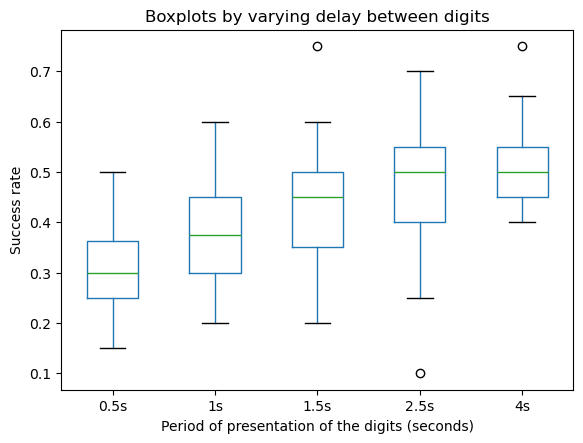

In [81]:
#eksperimetn 1 - ANOVA og boxplot

D1 = pd.read_csv("Ali\eksperiment1.csv")
D2 = pd.read_csv("Carl\eksperiment1.csv")
D3 = pd.read_csv("Erik\eksperiment1.csv")
D4 = pd.read_csv("Kasper\eksperiment1.csv")

D_combined = pd.concat([D1,D2,D3,D4], ignore_index=True)
df_sorted = D_combined.sort_values(by='wait')

# Combine into a DataFrame
df = pd.DataFrame({'y': unpack_grouped_data(proportions(df_sorted,5,28))[0], 'treatm': unpack_grouped_data(proportions(df_sorted,5,28))[1]})

# Fit model
model = smf.ols('y ~ C(treatm)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)

ax = df.boxplot(column='y', by='treatm', grid=False)

# Customize plot
plt.title('Boxplots by varying delay between digits')
plt.suptitle('')  # Remove default subtitle
plt.xlabel('')    # Optional: remove x-axis label
plt.ylabel('Success rate')  # Y-axis label
plt.xlabel('Period of presentation of the digits (seconds)')
labelss = ['0.5s','1s','1.5s','2.5s','4s']


ax.set_xticklabels(labelss)

In [82]:
#Eks 1 - confidence

# compute_pairwise_CIs(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])
df = compute_pairwise_CIs(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])
df[['Mean diff','CI Lower','CI Upper']] = df[['Mean diff','CI Lower','CI Upper']].applymap(lambda x: f"{x:.2}")
df['p-value'] = df['p-value'].map(format_p_value_latex)
print(df.to_latex(index=False))

\begin{tabular}{llllll}
\toprule
Group 1 & Group 2 & Mean diff & CI Lower & CI Upper & p-value \\
\midrule
0.5s & 1s & -0.059 & -0.12 & -0.0012 & 0.045 \\
0.5s & 1.5s & -0.12 & -0.18 & -0.062 & $7.14 \times 10^{-5}$ \\
0.5s & 2.5s & -0.16 & -0.21 & -0.098 & $4.19 \times 10^{-7}$ \\
0.5s & 4s & -0.2 & -0.26 & -0.14 & $3.98 \times 10^{-10}$ \\
1s & 1.5s & -0.061 & -0.12 & -0.003 & 0.039 \\
1s & 2.5s & -0.096 & -0.15 & -0.039 & 0.001 \\
1s & 4s & -0.14 & -0.2 & -0.083 & $4.64 \times 10^{-6}$ \\
1.5s & 2.5s & -0.036 & -0.093 & 0.022 & 0.223 \\
1.5s & 4s & -0.081 & -0.14 & -0.023 & 0.007 \\
2.5s & 4s & -0.046 & -0.1 & 0.013 & 0.127 \\
\bottomrule
\end{tabular}



C:\Users\Ali\AppData\Local\Temp\ipykernel_35532\1441964966.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])
C:\Users\Ali\AppData\Local\Temp\ipykernel_35532\1733911060.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['Mean diff','CI Lower','CI Upper']] = df[['Mean diff','CI Lower','CI Upper']].applymap(lambda x: f"{x:.2}")


In [83]:
#Eks 1 - confidence
# group_vs_grand_mean_CIs(df,group_labels=['0.5s','1s','1.5s','2.5s','4s'])

In [84]:
#eksperiment 2

# Load the two CSV files
df1 = pd.read_csv('Carl\eksperiment2_WorkingMemoryFalse.csv') 
df2 = pd.read_csv('Ali\eksperiment2_WorkingMemoryFalse.csv') 
df3 = pd.read_csv('Erik\eksperiment2_WorkingMemoryFalse.csv') 
df7 = pd.read_csv('Kasper\eksperiment2_WorkingMemoryFalse.csv') 

df4 = pd.read_csv('Carl\eksperiment2_WorkingMemoryTrue.csv')
df5 = pd.read_csv('Ali\eksperiment2_WorkingMemoryTrue.csv')
df6 = pd.read_csv('Erik\eksperiment2_WorkingMemoryTrue.csv')
df8 = pd.read_csv('Kasper\eksperiment2_WorkingMemoryTrue.csv') 

# Concatenate the DataFrames
work_false_df = pd.concat([df1, df2,df3,df7], ignore_index=True)
work_true_df = pd.concat([df4,df5,df6,df8], ignore_index=True)

work_false = proportions(work_false_df,1,70)
work_false = work_false[0]
work_true = proportions(work_true_df,1,70)
work_true = work_true[0]

#Means
print(np.mean(work_false),np.mean(work_true))

# Paired t-test
t_stat, p_val = ttest_rel(work_false, work_true)

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val}')

#Confidence
stats.ttest_rel(work_false, work_true).confidence_interval(0.95)


0.3607142857142857 0.27071428571428574
T-statistic: 5.3576, p-value: 1.051120563996224e-06


ConfidenceInterval(low=np.float64(0.0564876116777752), high=np.float64(0.12351238832222483))

In [85]:
def calcAcc(D1):
    
    D1['number_of_letters'] = D1['correctSequence'].apply(lambda x: len(x))
    # D1[D1['number_of_letters']==3]
    accuracies = []
    for idx,row in D1.iterrows():
        corrects = 0
        for correct_str, guess_str in zip(row['correctSequence'], row['userInput']):
            if correct_str == guess_str:
                corrects += 1
        accuracies.append(corrects / len(row['correctSequence']))
    D1['accuracies'] = np.array(accuracies)

              df    sum_sq   mean_sq         F    PR(>F)
C(treatm)    7.0  0.114163  0.016309  4.229971  0.000271
Residual   153.0  0.589902  0.003856       NaN       NaN


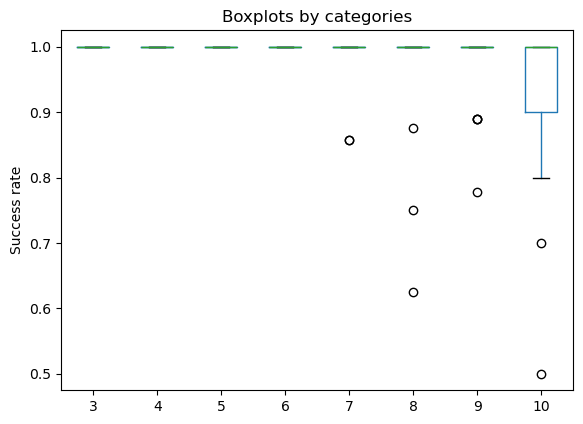

In [86]:
# eksperimetn 3

D1 = pd.read_csv("Carl\eksperiment3.csv")
D2 = pd.read_csv("Ali\eksperiment3.csv")
D3 = pd.read_csv("Erik\eksperiment3.csv")
D4= pd.read_csv("Kasper\eksperiment3.csv")

D = pd.concat([D1,D2,D3,D4], ignore_index=True)

# Convert string in column 1 to actual Python list and compute its length
D['length'] = D['correctSequence'].str.count("'") // 2

# Sort by length
df_sorted = D.sort_values(by='length')

# Drop the length column if you don’t want it in final result
df_sorted = df_sorted.drop(columns='length')

D = df_sorted
# Combine into a DataFrame
df = pd.DataFrame({'y': unpack_grouped_data(letters_proportions(D,8,21))[0], 'treatm': unpack_grouped_data(letters_proportions(D,8,21))[1]})

# Fit model
model = smf.ols('y ~ C(treatm)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
print(anova_table)
make_boxplot(df,group_labels=['3','4','5','6','7','8','9','10'])


In [87]:
compute_pairwise_CIs(df,group_labels=['3','4','5','6','7','8','9','10'])

C:\Users\Ali\AppData\Local\Temp\ipykernel_35532\1441964966.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group 1,Group 2,Mean diff,CI Lower,CI Upper,p-value
0,3,4,0.000000,-0.037857,0.037857,1.000000
1,3,5,0.000000,-0.037857,0.037857,1.000000
2,3,6,0.000000,-0.037857,0.037857,1.000000
3,3,7,0.013605,-0.024252,0.051462,0.478780
4,3,8,0.035714,-0.002143,0.073571,0.064270
5,3,9,0.026455,-0.011402,0.064312,0.169424
6,3,10,0.092857,0.050532,0.135183,0.000026
7,4,5,0.000000,-0.037857,0.037857,1.000000
8,4,6,0.000000,-0.037857,0.037857,1.000000
9,4,7,0.013605,-0.024252,0.051462,0.478780


In [88]:
group_vs_grand_mean_CIs(df,group_labels=['3','4','5','6','7','8','9','10'])

C:\Users\Ali\AppData\Local\Temp\ipykernel_35532\3508796942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('treatm')['y'].agg(['mean', 'count'])


,Group,Mean,Diff from Grand Mean,CI Lower,CI Upper
0,3,1.00e+00,1.80e-02,-8.81e-03,4.47e-02
1,4,1.00e+00,1.80e-02,-8.81e-03,4.47e-02
2,5,1.00e+00,1.80e-02,-8.81e-03,4.47e-02
3,6,1.00e+00,1.80e-02,-8.81e-03,4.47e-02
4,7,9.86e-01,4.35e-03,-2.24e-02,3.11e-02
5,8,9.64e-01,-1.78e-02,-4.45e-02,9.01e-03
6,9,9.74e-01,-8.50e-03,-3.53e-02,1.83e-02
7,10,9.07e-01,-7.49e-02,-1.08e-01,-4.21e-02


In [89]:
# eksperimetn 4

df1 = pd.read_csv("Carl\eksperiment4.csv")
df2 = pd.read_csv("Ali\eksperiment4.csv")
df3 = pd.read_csv("Erik\eksperiment4.csv")
df4 = pd.read_csv("Kasper\eksperiment4.csv")

df5 = pd.read_csv("Carl\eksperiment4_chunking.csv")
df6 = pd.read_csv("Ali\eksperiment4_chunking.csv")
df7 = pd.read_csv("Erik\eksperiment4_chunking.csv")
df8 = pd.read_csv("Kasper\eksperiment4_chunking.csv")

# Concatenate the DataFrames
finger_df = pd.concat([df1, df2,df3,df4], ignore_index=True)
lalala_df = pd.concat([df5,df6,df7,df8], ignore_index=True)

finger = letters_proportions(finger_df,1,70)
finger = finger[0]
lalala = letters_proportions(lalala_df,1,70)
lalala = lalala[0]

#Means
print(np.mean(finger),np.mean(lalala))

# Paired t-test
t_stat, p_val = ttest_rel(finger, lalala)

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

#Confidence
stats.ttest_rel(finger, lalala).confidence_interval(0.95)


0.9660714285714286 0.8592857142857143
T-statistic: 5.3284, p-value: 0.0000


ConfidenceInterval(low=np.float64(0.06680529694662095), high=np.float64(0.14676613162480756))

In [ ]:
#eksperiment 5

df1 = loadDataFrame("Carl\eksperiment5_finger.csv")
df2 = loadDataFrame("Ali\eksperiment5_finger.csv")
df3 = loadDataFrame("Erik\eksperiment5_finger.csv")
df4 = loadDataFrame("Kasper\eksperiment5_finger.csv")

df5 = loadDataFrame("Carl\eksperiment5_lalala.csv")
df6 = loadDataFrame("Ali\eksperiment5_lalala.csv")
df7 = loadDataFrame("Erik\eksperiment5_lalala.csv")
df8 = loadDataFrame("Kasper\eksperiment5_lalala.csv")

# Concatenate the DataFrames
finger_df = pd.concat([df1, df2,df3,df4], ignore_index=True)
lalala_df = pd.concat([df5,df6,df7,df8], ignore_index=True)

calcAcc(finger_df)
calcAcc(lalala_df)
finger_df
# finger = letters_proportions(finger_df,1,70)
# finger = finger[0]
# lalala = letters_proportions(lalala_df,1,70)
# lalala = lalala[0]

# #Means
# print(np.mean(finger),np.mean(lalala))

# # Paired t-test
t_stat, p_val = ttest_rel(finger_df['accuracies'], lalala_df['accuracies'])

print(f'T-statistic: {t_stat:.4f}, p-value: {p_val:.4f}')

#Confidence
stats.ttest_rel(finger, lalala).confidence_interval(0.95)


T-statistic: 5.3718, p-value: 0.0000


ConfidenceInterval(low=np.float64(0.06680529694662095), high=np.float64(0.14676613162480756))